# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [145]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pickle as pkl
import os
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.tree import DecisionTreeClassifier

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from prettytable import PrettyTable
from IPython.display import Image

In [4]:
# Read the Amazon fine food review data from database using sqlite 
con = sqlite3.connect('database.sqlite')

# Select all reviews where score is not 3 (neutral)
review_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", con)

# Assign positive class if score >=4 else assign negative class
score = review_data['Score']
PN_score = score.map(lambda x: "Positive" if x>=4 else "Negative")
review_data['Score'] = PN_score


print("Shape of review data is {}".format(review_data.shape))
review_data.head(3)

Shape of review data is (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [5]:
#Trying to visualize the duplicate data before removal
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [7]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [8]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [9]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
#sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
#final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
#final.shape

In [13]:
#Remove the duplicate entries from the data

sorted_data = review_data.sort_values('ProductId')
final = sorted_data.drop_duplicates(subset=["UserId", "Time", "Summary"])
print(final.shape)

(363186, 10)


In [15]:
#Checking to see how much % of data still remains
print((final['Id'].size*1.0)/(review_data['Id'].size*1.0)*100)

69.07119247490557


<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [16]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [18]:
# Removing the reviews where HelpfullnessNumerator > HelpfulnessDenominator

final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [20]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
print(final['Score'].value_counts())

(363184, 10)
Positive    306173
Negative     57011
Name: Score, dtype: int64


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [42]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

In [47]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [43]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
#remove spacial character: https://stackoverflow.com/a/5843547/4084039

In [116]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords = set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [55]:
from nltk.stem import SnowballStemmer

#Intializing SnowballStemmer
snow_stemmer = SnowballStemmer('english')

#Using Stemmer on a word
print(snow_stemmer.stem('Moves'))

move


In [48]:
# Combining all the above to clean reviews
from tqdm import tqdm
preprocessed_reviews = []

# tqdm is for printing the status bar
for sentence in tqdm(final['Text'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())

100%|████████████████████████████████████████████████████████████████████████| 363184/363184 [04:45<00:00, 1270.29it/s]


In [64]:
# Storing the preprocessed reviews and stemmed preprocessed reviews seperately.
# We have performed the cleaning on the whole data so we can use it later on
# models other than KNN that can handle high dimensional data gracefully.

#############---- storing the data into .sqlite file ------########################
# Reviews are present in preprocessed_reviews

final['CleanedText'] = preprocessed_reviews
    
#Store the data into a sqlite database
if not os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    c = conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()

In [91]:
# Performing stemming on the preprocessed reviews
final['CleanedText'] = preprocessed_reviews
stemmed_reviews = []

for sentence in final['CleanedText'].values:
    sentence = b' '.join((snow_stemmer.stem(word)).encode('utf8') for word in sentence.split())
    stemmed_reviews.append(sentence)

In [85]:
final['CleanedText'] = stemmed_reviews
final['CleanedText'] = final['CleanedText'].str.decode("utf-8")

if not os.path.isfile('final_stemmedreviews.sqlite'):
    conn = sqlite3.connect('final_stemmedreviews.sqlite')
    c = conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()

In [3]:
# Load the preprocessed dataset from the database final.sqlite
# Data is ordered by time stamps to facilitate time base splitting
# of data for cross validation 

conn = sqlite3.connect('final.sqlite')
final = pd.read_sql_query("""SELECT * From Reviews ORDER BY Time""", conn)
conn.close()

conn = sqlite3.connect('final_stemmedreviews.sqlite')
final_stemmed = pd.read_sql_query("""SELECT * From Reviews ORDER BY Time""", conn)
conn.close()

In [4]:
# There is an extra index column in the data
final.head(1)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...


In [5]:
#Removing the index column from data
clean_data = final.drop(['index'], axis=1)

#clean_data_stemmed = final_stemmed.drop(['index'], axis=1)

# Map postive to 1 and negative to 0 in Score column
score = clean_data['Score']
bin_score = score.map(lambda x: 1 if x == "Positive" else 0)
clean_data['Score'] = bin_score

# Add stemmed reviews as an extra column in the data
# This will be in addition to the preprocessed non stemmed
# reviews which are stored in the CleanedText column.

stemmed_reviews = final_stemmed['CleanedText']
clean_data['StemmedText'] = stemmed_reviews

In [6]:
# Adding another feature into the data
# we will find the length of the each review
# and add that as a feature into the existing
# dataframe.

clean_data['Reviewlen'] = clean_data['StemmedText'].apply(len)

In [7]:
clean_data.tail(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,StemmedText,Reviewlen
363183,5703,B009WSNWC4,AMP7K1O84DH1T,ESTY,0,0,1,1351209600,DELICIOUS,Purchased this product at a local store in NY ...,purchased product local store ny kids love qui...,purchas product local store ny kid love quick ...,109


In [8]:
# Split the dataset in training and test dataset
# We will use the training data for cross validation and training.
# Test data will not be known to model and will be used
# to calculate the accuracy.

# Data is split in 70-30 train-test split using slicing since 
# data is sorted in ascending time order

# Instead of splitting the data and then sampling
# let's try to split the 100k samples directly and
# then just simple time split the data in 70-30k

data = clean_data.iloc[:,:]
subset_data = data.iloc[100000:200000,:]

train_cv_split = 70000

train = subset_data.iloc[:train_cv_split,:]
test = subset_data.iloc[train_cv_split:,:]

print(train.shape , '\n', test.shape)

(70000, 13) 
 (30000, 13)


In [9]:
print(train[train['Score'] == 0].shape)
print(test[test['Score'] == 0].shape)

(11235, 13)
(4961, 13)


In [10]:
# Seperating the Score column from rest of the data
columns = list(clean_data.columns)
columns = [column for column in columns if column != 'Score']

X_train = train[columns]
y_train = train['Score']

X_test = test[columns]
y_test = test['Score']

print(X_train.shape , y_train.shape, '\n', X_test.shape, y_test.shape)

(70000, 12) (70000,) 
 (30000, 12) (30000,)


In [11]:
# Save the y_train and y_test so we
# can directly use it later rather than rerunning
# the splitting steps again

pkl.dump(y_train, open("y_train.pkl", 'wb'))
pkl.dump(y_test, open("y_test.pkl", 'wb'))

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [6]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [ ]:
# Obtanining a vectorizer on stemmed reviews
# It was observed during Word2Vec transformation
# that stemmed reviews give words which are close to
# say good or bad otherwise we observe other words
# which seem non-relevant. So we will use stemmed reviews.

# Words in stemmed review that are most similar to great and worst
#[('wonder', 0.7626501321792603), ('awesom', 0.7493463754653931), ('excel', 0.7475039958953857), 
#('fantast', 0.7294141054153442), ('good', 0.7276639938354492), ('terrif', 0.6968766450881958), 
#('nice', 0.6279305219650269), ('perfect', 0.6089357733726501), ('amaz', 0.5737729072570801), 
#('decent', 0.5731742978096008)]
#==================================================
#[('horribl', 0.7659773826599121), ('disgust', 0.7506155967712402), ('terribl', 0.7292218208312988), 
#('aw', 0.7216229438781738), ('nasti', 0.6849608421325684), ('foul', 0.6611321568489075),
#('gag', 0.6592600345611572), ('weird', 0.6567815542221069), ('funni', 0.6493463516235352), 
#('gross', 0.6418379545211792)]

# Words in stemmed review that are most similar to great and worst
# As we can see worst is similar to greatest and best in non-stemmed reviews.

#[('awesome', 0.7547115087509155), ('fantastic', 0.7433849573135376), ('wonderful', 0.7318088412284851), 
#('excellent', 0.7240736484527588), ('good', 0.7088381052017212), ('terrific', 0.6650570631027222), 
#('amazing', 0.6410914659500122), ('perfect', 0.6294776201248169), ('fabulous', 0.624772310256958), 
#('incredible', 0.5898726582527161)]
#==================================================
#[('greatest', 0.7661513090133667), ('best', 0.668804407119751), ('richest', 0.6509857177734375), 
#('smoothest', 0.6451543569564819), ('nastiest', 0.639174222946167), ('tastiest', 0.6162684559822083), 
#('encountered', 0.6121875047683716), ('disgusting', 0.600991427898407), ('yummiest', 0.5978026390075684), 
#('nicest', 0.5876485705375671)]

In [14]:
# Running count vectorizer on training data only
# to avoid data leakage
# we will use the uni-grams & bi-grams in BoW embedding
# count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
count_vec = CountVectorizer(ngram_range=(1,2), min_df=10)

X_train_bow = count_vec.fit_transform(X_train['StemmedText'].values)
X_test_bow = count_vec.transform(X_test['StemmedText'].values)

# Save the training and test BOW vectors in pickle files
# We can simply load this data later and use it

pkl.dump(X_train_bow, open("train_bow.pkl", 'wb'))
pkl.dump(X_test_bow, open("test_bow.pkl", 'wb'))
pkl.dump(count_vec, open("count_vec.pkl", 'wb'))

## [4.2] TF-IDF

In [16]:
# Apply tfidf vectorizer to convert text to vectors

tf_idf = TfidfVectorizer(ngram_range=(1,2), min_df=10)

X_train_tfidf = tf_idf.fit_transform(X_train['StemmedText'].values)
X_test_tfidf = tf_idf.transform(X_test['StemmedText'].values)

# Save the training, CV and test TFIDF vectors in pickle files
# We can simply load this data later and use it

pkl.dump(X_train_tfidf, open("train_tfidf.pkl", 'wb'))
pkl.dump(X_test_tfidf, open("test_tfidf.pkl", 'wb'))
pkl.dump(tf_idf, open("tf_idf.pkl", 'wb'))

In [17]:
# Creating a dictionary with word as key and it's tfidf representation as value
dictionary = dict(zip(tf_idf.get_feature_names(), list(tf_idf.idf_)))

pkl.dump(dictionary, open("tfidf_dictionary.pkl", 'wb'))

## [4.3] Word2Vec

In [11]:
# Train our own Word2Vec model using your own text corpus

list_of_sent_test = []
list_of_sent_train = []

for review in X_test['StemmedText'].values:
    list_of_sent_test.append(review.split())

for review in X_train['StemmedText'].values:
    list_of_sent_train.append(review.split())

w2v = Word2Vec(list_of_sent_train, min_count=5, size=100, workers=4)
w2v.save('w2v_model.bin')
w2v_words = list(w2v.wv.vocab)

In [12]:
print(w2v.wv.most_similar('great'))
print('='*50)
print(w2v.wv.most_similar('bad'))

[('fantast', 0.7587853670120239), ('excel', 0.7455682158470154), ('wonder', 0.7229946255683899), ('awesom', 0.71524977684021), ('terrif', 0.7025073170661926), ('good', 0.6795937418937683), ('nice', 0.6322954893112183), ('fabul', 0.6186696290969849), ('perfect', 0.6119387149810791), ('amaz', 0.54731285572052)]
[('horribl', 0.706422746181488), ('terribl', 0.7024113535881042), ('aw', 0.674425482749939), ('gross', 0.6607470512390137), ('funni', 0.6481426954269409), ('ok', 0.6144280433654785), ('disgust', 0.602908730506897), ('weird', 0.5965282917022705), ('good', 0.5843976736068726), ('nasti', 0.5837870836257935)]


In [13]:
w2v_words = list(w2v.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:100])

number of words that occured minimum 5 times  11131
sample words  ['hey', 'good', 'stuff', 'like', 'tasti', 'cold', 'hot', 'flavor', 'subtl', 'yet', 'distinct', 'perfect', 'caffin', 'pick', 'frequent', 'use', 'creamer', 'better', 'coffe', 'qualiti', 'no', 'bitter', 'aftertast', 'drank', 'without', 'milk', 'way', 'found', 'not', 'need', 'sugar', 'also', 'made', 'big', 'glass', 'ice', 'top', 'whip', 'cream', 'local', 'coffeehous', 'final', 'tast', 'test', 'write', 'review', 'toss', 'strong', 'brew', 'blender', 'dark', 'chocol', 'yum', 'ok', 'enough', 'gotta', 'go', 'order', 'run', 'let', 'see', 'els', 'make', 'bye', 'husband', 'fallen', 'love', 'alway', 'ad', 'hazlenut', 'morn', 'cup', 'joe', 'creme', 'brule', 'favorit', 'dessert', 'decid', 'give', 'tri', 'total', 'winner', 'high', 'pressur', 'machin', 'know', 'would', 'much', 'regular', 'drip', 'maker', 'least', 'sweet', 'gave', 'star', 'base', 'rate', 'thought', 'bag', 'melitta']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [117]:
# Avg-W2V
from tqdm import tqdm

train_review_vectors = []
test_review_vectors = []

dataset = [(list_of_sent_train, train_review_vectors),
           (list_of_sent_test, test_review_vectors)]

for item in dataset:
    for review in tqdm(item[0]):
        nwords = 0
        rev_vec = np.zeros(100)
        for word in review:
            if word in w2v_words:
                vec = w2v.wv[word]
                rev_vec += vec
                nwords += 1
        if nwords != 0:
            rev_vec /= nwords
        item[1].append(rev_vec)

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [00:43<00:00, 686.55it/s]


In [118]:
# Save the review vectors so we can use later

pkl.dump(train_review_vectors, open("train_avgw2v.pkl", 'wb'))
pkl.dump(test_review_vectors, open("test_avgw2v.pkl", 'wb'))

#### [4.4.1.2] TFIDF weighted W2v

In [14]:
tf_idf = TfidfVectorizer(ngram_range=(1,2), min_df=10)

X_train_tfidf = tf_idf.fit_transform(X_train['StemmedText'].values)
X_test_tfidf = tf_idf.transform(X_test['StemmedText'].values)

dictionary_tfidf = dict(zip(tf_idf.get_feature_names(), list(tf_idf.idf_)))
tfidf_features = tf_idf.get_feature_names()

In [15]:
# review_vectors will store the tfidf-weighted W2V representation of the reviews in the dataset

# TFIDFWeighted-W2V
from tqdm import tqdm

train_review_vectors = []
test_review_vectors = []

list_of_sent_test = []
list_of_sent_train = []

for review in X_test['CleanedText'].values:
    list_of_sent_test.append(review.split())

for review in X_train['CleanedText'].values:
    list_of_sent_train.append(review.split())

dataset = [(list_of_sent_train, train_review_vectors),
           (list_of_sent_test, test_review_vectors)]

w2v_model = Word2Vec.load('w2v_model.bin')
w2v_words = list(w2v_model.wv.vocab)


for item in dataset:
    row=0
    for review in tqdm(item[0]): 
        rev_vec = np.zeros(100)
        weight_sum = 0
        for word in review:
            if word in w2v_words and word in tfidf_features:
                vec = w2v_model.wv[word]
                tf_idf = dictionary_tfidf[word]*(review.count(word)/len(review))
                rev_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            rev_vec /= weight_sum
        item[1].append(rev_vec)
        row += 1

100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [16:10<00:00, 30.92it/s]


In [16]:
# Save the review vectors so we can use later

pkl.dump(train_review_vectors, open("train_tfidfw2v.pkl", 'wb'))
pkl.dump(test_review_vectors, open("test_tfidfw2v.pkl", 'wb'))

## Utility Functions used in Decision Trees

In [95]:
# This function takes the vector representation of review data 
# and returns the optimal depth of the tree and minimum samples
# left till we split for Decision Tree using 5-fold
# cross validation in GridSearchCV.
# Code below makes use of TimeSeriesSplit.

def get_optimal_hyperparams(X_train, y_train):
    parameters = {'max_depth' : [1, 5, 10, 50, 100, 500, 1000], \
                  'min_samples_split' : [5, 10, 100, 500]}

    #Perform GridSearch
    cv_obj = TimeSeriesSplit(n_splits=5).split(X_train)
    clf = GridSearchCV(DecisionTreeClassifier(), parameters, 
                        scoring = 'roc_auc', cv=cv_obj)
    clf.fit(X_train, y_train)

    #tree_depth = parameters['max_depth']
    #min_samples = parameters['min_samples_split']
    gresults = clf.cv_results_
    hyper_params = gresults['params']

    auc_scores_train = gresults['mean_train_score']
    auc_scores_cv = gresults['mean_test_score']
    #print("cv_results : {}".format(gresults))
    #print("Best : {}".format(clf.best_score_))
    #optimal_c = c_values[results['rank_test_score'][0]-1]
    optimal_depth = gresults['params'][clf.best_index_]['max_depth']
    optimal_minsplit = gresults['params'][clf.best_index_]['min_samples_split']
    #print(clf.best_estimator_)
    #print(clf.best_index_, '\t', optimal_depth, '\t', optimal_minsplit)
    return optimal_depth, optimal_minsplit, zip(hyper_params, 
                                                auc_scores_train, auc_scores_cv)

In [96]:
# Running Decision Tree Classifier with given max_depth
# and min_samples_split value and returns a tuple indicating 
# AUC obtained for test data along with the confusion matrix 
# along with the classifier object. Same function can be used 
# on all vectorized data irrespective of vectorizer

def run_dt(X_train, y_train, X_test, y_test, depth, minsplit):
    dt_clf = DecisionTreeClassifier(max_depth=depth, 
                                    min_samples_split= minsplit)
    dt_clf.fit(X_train, y_train)

    y_pred_test = dt_clf.predict_proba(X_test)
    y_pred_train = dt_clf.predict_proba(X_train)

    y_pred_test_prob = y_pred_test[:,1]
    y_pred_test_label = np.argmax(y_pred_test, axis=1)

    y_pred_train_prob = y_pred_train[:,1]
    y_pred_train_label = np.argmax(y_pred_train, axis=1)

    fpr_test, tpr_test, thresholds_test = roc_curve(y_test,\
                                                    y_pred_test_prob)
    auc_score_test = auc(fpr_test, tpr_test)

    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, \
                                                       y_pred_train_prob)
    auc_score_train = auc(fpr_train, tpr_train)

    conf_mat = confusion_matrix(y_test, y_pred_test_label)

    plt.figure()
    plt.plot(fpr_train, tpr_train, color='darkorange', lw=1, \
             label='Train ROC curve (area = %0.2f)' % auc_score_train)
    plt.plot(fpr_test, tpr_test, color='navy', lw=1, \
             label='Test ROC curve (area = %0.2f)' % auc_score_test)
    plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    plt.close()
    return dt_clf, auc_score_test, conf_mat

In [88]:
def plot_confusion_matrix(cm):
    labels = ['Negative', 'Positive']
    confmat = pd.DataFrame(cm, index = labels, columns = labels)
    sns.heatmap(confmat, annot = True, fmt = 'd', cmap="Greens")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [86]:
# All the results will be stored in the results dataframe and
# later in we will use this dataframe to print the results
# in tabular format

results = pd.DataFrame(
    columns=['Features-Used', 'Vectorizer', 'Max Depth', 'Min Samples Split', 'AUC'])

In [87]:
import prettytable as pt
# function to print the results obtained in a table format
def print_results(data):
    result = PrettyTable(hrules=pt.ALL, 
                         vrules=pt.ALL, padding_width=2)
    result.field_names = list(data.columns)
    for i in range(0, data.shape[0]):
        result.add_row(data.iloc[i])
    print(result)

In [74]:
# Function to plot the heatmap of AUC scores
# for validation and training auc scores against
# the parameter grid i.e. max_depth and min_sampls_split
def plot_heatmap(params, auc_scores, flag):
    max_depth = sorted(set([item['max_depth'] \
                            for item in params]))
    min_samples_split = sorted(set([item['min_samples_split'] \
                                    for item in params]))

    auc_scores = np.array(auc_scores).reshape(len(min_samples_split), 
                                              len(max_depth))
    auc_scores_mat = pd.DataFrame(auc_scores, 
                                  index=min_samples_split, 
                                  columns=max_depth)

    clr = sns.color_palette("Blues")
    ax = sns.heatmap(auc_scores_mat, annot = True, cmap=clr)
    ax.invert_yaxis()
    plt.title("Heat Map for {} AUC scores".format(flag))
    plt.xlabel("Max Depth")
    plt.ylabel("Minimum Sample Split")
    plt.show()

# Applying Decision Trees

## [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

Optimal Max Depth : 50
Optimal Min Samples Split : 500


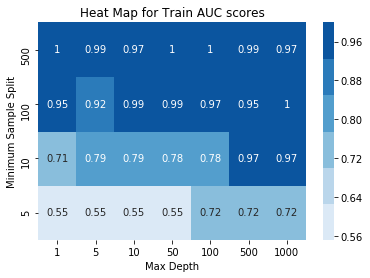

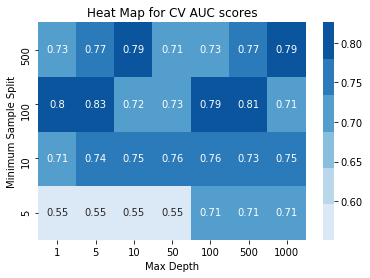

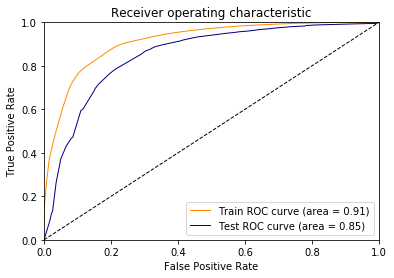

AUC score:
 0.85


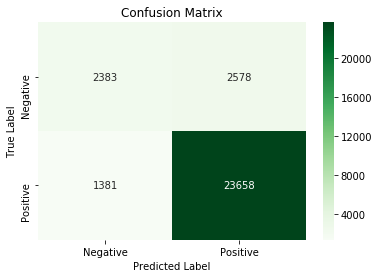

In [97]:
# Load the saved vectorized data for train-test datapoints
X_train_bow = pkl.load(open('train_bow.pkl', 'rb'))
X_test_bow = pkl.load(open('test_bow.pkl', 'rb'))

# Getting an optimal value of hyperparameter max_depth
# and min_samples_split. This data is used to plot a heatmap
# There will be a problem of data leakage while using
# Gridsearch on train data but no way to get around it.
# Test data doesn't have this problem since it is transformed
# using the vectorizer fit on training data.
depth, minsplit, auc_scores = get_optimal_hyperparams(X_train_bow, 
                                                 y_train)

params, train_auc, cv_auc = zip(*auc_scores)
print("Optimal Max Depth : {}".format(depth))
print("Optimal Min Samples Split : {}".format(minsplit))

# Plotting hyperparameter values vs AUC scores
plot_heatmap(params, train_auc, flag="Train")
plot_heatmap(params, cv_auc, flag="CV")

# Running Decision Tree Classifier with optimal value
# of max depth and min samples split obtained
dt_clf, auc_score, conf_mat = run_dt(X_train_bow, y_train, 
                                     X_test_bow, y_test, 
                                     depth, minsplit)

print("AUC score:\n {:.2f}".format(auc_score))

# Plotting confusion matrix
plot_confusion_matrix(conf_mat)

auc_score = '%0.2f' % auc_score

# Adding the results to our results dataframe
results.loc[results.shape[0]] = ["Review Text", "BoW", depth, minsplit, auc_score]

### [5.1.1] Top 20 important features from<font color='red'> SET 1</font>

In [129]:
# Loading the saved count vectorizer object
count_vec = pkl.load(open("count_vec.pkl", 'rb'))

# Top 20 features as per feature importance
top_indices = np.argsort(-dt_clf.feature_importances_)[:20, None]
print(np.take(count_vec.get_feature_names(), top_indices))

[['disappoint']
 ['not buy']
 ['wast money']
 ['not disappoint']
 ['great']
 ['not']
 ['love']
 ['worst']
 ['return']
 ['best']
 ['aw']
 ['horribl']
 ['delici']
 ['refund']
 ['good']
 ['not worth']
 ['not good']
 ['not recommend']
 ['terribl']
 ['perfect']]


### [5.1.2] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

In [132]:
# The Graphical representation of decision tree
# is being saved in a png file named tree_bow.png
# Restricting the tree to depth 3.

from sklearn.tree import export_graphviz

export_graphviz(dt_clf, out_file='dt_graph_bow', max_depth=3, 
                feature_names=count_vec.get_feature_names(), 
                class_names=['Negative', 'Positive'])

### Graphical representation of Decision Tree(BoW)

![title](tree_bow.png)

## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

Optimal Max Depth : 50
Optimal Min Samples Split : 500


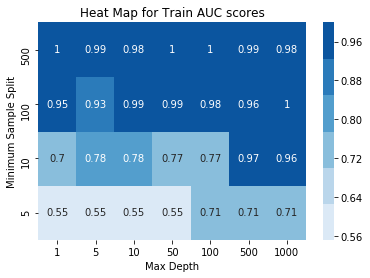

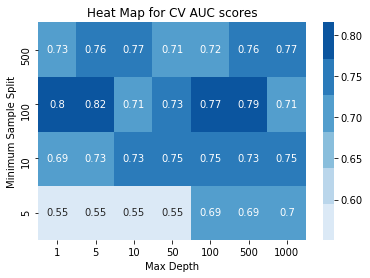

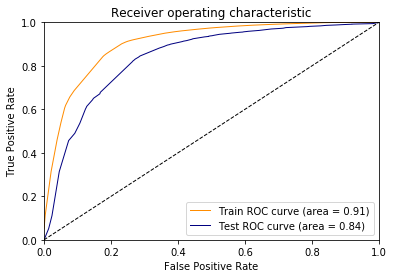

AUC score:
 0.84


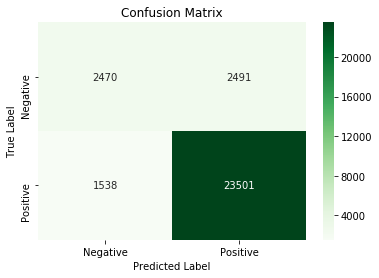

In [139]:
# Load the saved vectorized data for train-test datapoints
X_train_tfidf = pkl.load(open('train_tfidf.pkl', 'rb'))
X_test_tfidf = pkl.load(open('test_tfidf.pkl', 'rb'))


# Getting an optimal value of hyperparameter max_depth
# and min_samples_split. This data is used to plot a heatmap
# There will be a problem of data leakage while using
# Gridsearch on train data but no way to get around it.
# Test data doesn't have this problem since it is transformed
# using the vectorizer fit on training data.
depth, minsplit, auc_scores = get_optimal_hyperparams(X_train_tfidf, 
                                                 y_train)

params, train_auc, cv_auc = zip(*auc_scores)
print("Optimal Max Depth : {}".format(depth))
print("Optimal Min Samples Split : {}".format(minsplit))

# Plotting hyperparameter values vs AUC scores
plot_heatmap(params, train_auc, flag="Train")
plot_heatmap(params, cv_auc, flag="CV")

# Running Decision Tree Classifier with optimal value
# of max depth and min samples split obtained
dt_clf, auc_score, conf_mat = run_dt(X_train_tfidf, y_train, 
                                     X_test_tfidf, y_test, 
                                     depth, minsplit)

print("AUC score:\n {:.2f}".format(auc_score))

# Plotting confusion matrix
plot_confusion_matrix(conf_mat)

auc_score = '%0.2f' % auc_score

# Adding the results to our results dataframe
results.loc[results.shape[0]] = ["Review Text", "TF-IDF", depth, minsplit, auc_score]

### [5.1.1] Top 20 important features from<font color='red'> SET 2</font>

In [140]:
# Loading the saved tf-idf vectorizer object
tf_idf = pkl.load(open("tf_idf.pkl", 'rb'))

# Top 20 features as per feature importance
top_indices = np.argsort(-dt_clf.feature_importances_)[:20, None]
print(np.take(tf_idf.get_feature_names(), top_indices))

[['disappoint']
 ['not']
 ['not disappoint']
 ['great']
 ['not buy']
 ['worst']
 ['return']
 ['love']
 ['wast money']
 ['aw']
 ['horribl']
 ['refund']
 ['best']
 ['threw']
 ['good']
 ['terribl']
 ['delici']
 ['money']
 ['disgust']
 ['not worth']]


### [5.2.2] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

In [142]:
# The Graphical representation of decision tree
# is being saved in a png file named tree_tfidf.png
# Restricting the tree to depth 3.

from sklearn.tree import export_graphviz

export_graphviz(dt_clf, out_file='dt_graph_tfidf', max_depth=3, 
                feature_names=count_vec.get_feature_names(), 
                class_names=['Negative', 'Positive'])

### Graphical representation of Decision Tree(TF-IDF)

![title](tree_tfidf.png)

## [5.3] Applying Decision Trees on AVG W2V<font color='red'> SET 3</font>

Optimal Max Depth : 10
Optimal Min Samples Split : 500


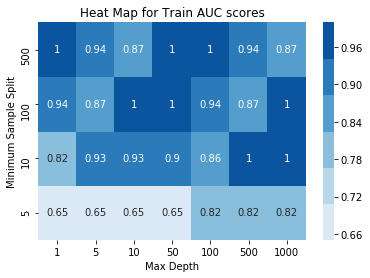

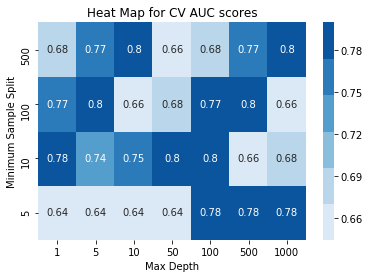

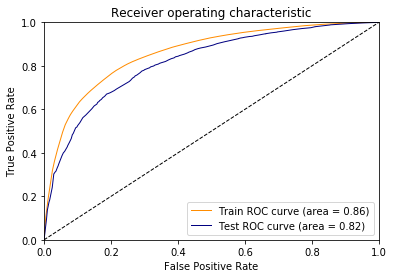

AUC score:
 0.82


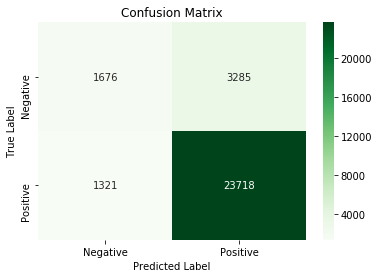

In [135]:
# Load the saved vectorized data for train-test datapoints
X_train_avgw2v = pkl.load(open('train_avgw2v.pkl', 'rb'))
X_test_avgw2v = pkl.load(open('test_avgw2v.pkl', 'rb'))

# Getting an optimal value of hyperparameter max_depth
# and min_samples_split. This data is used to plot a heatmap
# There will be a problem of data leakage while using
# Gridsearch on train data but no way to get around it.
# Test data doesn't have this problem since it is transformed
# using the vectorizer fit on training data.
depth, minsplit, auc_scores = get_optimal_hyperparams(X_train_avgw2v, 
                                                 y_train)

params, train_auc, cv_auc = zip(*auc_scores)
print("Optimal Max Depth : {}".format(depth))
print("Optimal Min Samples Split : {}".format(minsplit))

# Plotting hyperparameter values vs AUC scores
plot_heatmap(params, train_auc, flag="Train")
plot_heatmap(params, cv_auc, flag="CV")

# Running Decision Tree Classifier with optimal value
# of max depth and min samples split obtained
dt_clf, auc_score, conf_mat = run_dt(X_train_avgw2v, y_train, 
                                     X_test_avgw2v, y_test, 
                                     depth, minsplit)

print("AUC score:\n {:.2f}".format(auc_score))

# Plotting confusion matrix
plot_confusion_matrix(conf_mat)

auc_score = '%0.2f' % auc_score

# Adding the results to our results dataframe
results.loc[results.shape[0]] = ["Review Text", "AvgW2V", depth, minsplit, auc_score]

## [5.4] Applying Decision Trees on TFIDF W2V<font color='red'> SET 4</font>

Optimal Max Depth : 10
Optimal Min Samples Split : 500


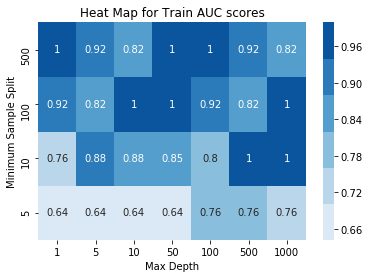

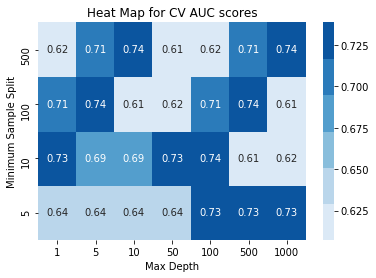

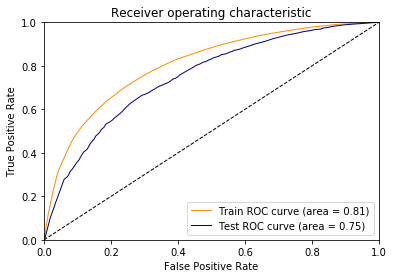

AUC score:
 0.75


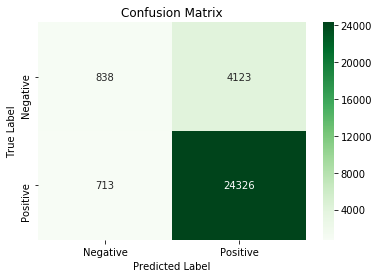

In [136]:
# Load the saved vectorized data for train-test datapoints
X_train_tfidfw2v = pkl.load(open('train_tfidfw2v.pkl', 'rb'))
X_test_tfidfw2v = pkl.load(open('test_tfidfw2v.pkl', 'rb'))

# Getting an optimal value of hyperparameter max_depth
# and min_samples_split. This data is used to plot a heatmap.
# There will be a problem of data leakage while using
# Gridsearch on train data but no way to get around it.
# Test data doesn't have this problem since it is transformed
# using the vectorizer fit on training data.
depth, minsplit, auc_scores = get_optimal_hyperparams(X_train_tfidfw2v, 
                                                 y_train)

params, train_auc, cv_auc = zip(*auc_scores)
print("Optimal Max Depth : {}".format(depth))
print("Optimal Min Samples Split : {}".format(minsplit))

# Plotting hyperparameter values vs AUC scores
plot_heatmap(params, train_auc, flag="Train")
plot_heatmap(params, cv_auc, flag="CV")

# Running Decision Tree Classifier with optimal value
# of max depth and min samples split obtained
dt_clf, auc_score, conf_mat = run_dt(X_train_tfidfw2v, y_train, 
                                     X_test_tfidfw2v, y_test, 
                                     depth, minsplit)

print("AUC score:\n {:.2f}".format(auc_score))

# Plotting confusion matrix
plot_confusion_matrix(conf_mat)

auc_score = '%0.2f' % auc_score

# Adding the results to our results dataframe
results.loc[results.shape[0]] = ["Review Text", "Tfidf-W2V", depth, minsplit, auc_score]

# [6] Conclusions

1. We tried BoW, TF-IDF, Average Word2Vec and Tfidf weighted Word2Vec vectorizers on 
   Decision Tree Classifier.


2. AUC score for Decision Tree classifier was better for BoW and TFIDF vectorizers.


3. BoW :

      Top 20 important features
      
      'disappoint' , 'not buy', 'wast money', 'not disappoint', 'great', 'not', 
      
      'love', 'worst', 'return', 'best', 'aw', 'horribl', 'delici', 'refund', 
      
      'good', 'not worth', 'not good', 'not recommend', 'terribl', 'perfect'


4. TFIDF :

      Top 20 important features

      'disappoint', 'not', 'not disappoint', 'great', 'not buy', 'worst', 'return', 
      
      'love', 'wast money', 'aw', 'horribl', 'refund', 'best', 'threw', 'good', 
      
      'terribl', 'delici', 'money', 'disgust', 'not worth'


In [152]:
print_results(results)

+-----------------+--------------+-------------+---------------------+--------+
|  Features-Used  |  Vectorizer  |  Max Depth  |  Min Samples Split  |  AUC   |
+-----------------+--------------+-------------+---------------------+--------+
|   Review Text   |     BoW      |      50     |         500         |  0.85  |
+-----------------+--------------+-------------+---------------------+--------+
|   Review Text   |    TF-IDF    |      50     |         500         |  0.84  |
+-----------------+--------------+-------------+---------------------+--------+
|   Review Text   |    AvgW2V    |      10     |         500         |  0.82  |
+-----------------+--------------+-------------+---------------------+--------+
|   Review Text   |  Tfidf-W2V   |      10     |         500         |  0.75  |
+-----------------+--------------+-------------+---------------------+--------+
